In [37]:
import sqlite3
import requests
from bs4 import BeautifulSoup
import time
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

db_name = 'real_estate.db'

# 取得したいURLをここに並べてください（例：エリア別のURLなど）
target_urls = ["https://www.yokohama-fudousan.com/mansion/kanagawa/result/"]
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36'}

DB

In [38]:
# DBファイルの保存先パス
path = ''

# Google Colabの場合
# path = '/content/'

# DBファイル
db_name = 'real_estate.db'

# DB接続の確立
# DBファイルが存在しない場合は新規作成される
conn = sqlite3.connect(path + db_name)

# DBへの接続を閉じる
conn.close()

In [39]:
path = ''
db_name = 'real_estate.db'

try:
    # DB接続オブジェクトの作成
    conn = sqlite3.connect(path + db_name)

    # SQL（RDBを操作するための言語）を実行するためのカーソルオブジェクトを取得
    cur = conn.cursor()

    # すでにテーブルがある場合は作り直すために削除（初期化用）
    cur.execute('DROP TABLE IF EXISTS real_estate;')

    # SQL文の作成
    # リポジトリ名(repositories_name), 主要な言語(language), スター数(stars)
    sql = '''
          CREATE TABLE 不動産 (
              id INT NOT NULL,
              name VARCHAR(100) NOT NULL,
              price INT NOT NULL,
              Management_fee INT NOT NULL,
              area NUMERIC(6, 2) NOT NULL,
              Walking_minutes INT NOT NULL,
              Year_of_construction DATE NOT NULL,
              floor INT NOT NULL,
              floor_plan VARCHAR(50) NOT NULL,
              PRIMARY KEY (id)
          );
          '''

    # SQL文の実行
    cur.execute(sql)

except sqlite3.Error as e:
    print('エラーが発生しました:', e)

finally:
    # DBへの接続を閉じる
    conn.close()

エラーが発生しました: table 不動産 already exists


変換処理

In [40]:
def convert_price(price_text):
    if not price_text or price_text in ["未定", "Unknown", "0"]:  # 空文字、"Unknown"、"0"の場合の処理
        return 0
    price_text = price_text.replace(",", "")
    if "万円" in price_text:
        price_text = price_text.replace("万円", "")
        return int(float(price_text) * 10000)
    match = re.search(r'(\d+\.?\d*)', str(price_text).replace(",", ""))
    if match:
        return int(float(match.group(1)) * 10000)
    return 0

def convert_management_fee(management_fee_text):
    if not management_fee_text or management_fee_text in ["未定", "Unknown", "0"]: 
        return 0
    management_fee_text = management_fee_text.replace(",", "")
    if "万円" in management_fee_text:
        management_fee_text = management_fee_text.replace("万円", "")
        return int(float(management_fee_text) * 10000)

def convert_area(area_text):
    if not area_text or area_text in ["未定", "Unknown", "0"]: 
        return 0.0
    match = re.search(r'(\d+\.?\d*)', area_text.replace(',', ''))
    if match:
        return float(match.group(1))
    return 0.0

def convert_minutes(minutes_text):
    if not minutes_text or minutes_text in ["未定", "Unknown", "0"]:
        return 0
    match = re.search(r'\d+', str(minutes_text))
    if match:
        return int(match.group())
    return 0

スクレイピング

In [41]:
# DB接続を再開
conn = sqlite3.connect(path + db_name)
cur = conn.cursor()

cur.execute("DELETE FROM 不動産")
conn.commit()

total_count = 0
print(f"スクレイピングを開始（対象: {len(target_urls)} ページ）")

total_count = 0 # 全体の合計件数を初期化

try:
    for i, url in enumerate(target_urls, 1):
        print(f"[{i}/{len(target_urls)}] 取得中: {url}")

        count_in_page = 0

        #ページを取得する
        try:
            res = requests.get(url, headers=headers, timeout=10)
            res.raise_for_status()
            soup = BeautifulSoup(res.text, 'html.parser') 
        except Exception as e:
            print(f"  -> ページ取得エラー: {e}")
            continue

        #物件リストの取得
        items = soup.find_all('div', class_='article-object') 
        print(f"ページ内の検索一致数: {len(items)} 件")

        for i, item in enumerate(items, 1):
            # 物件名
            name_el = item.find('p', class_='object-name')
            if not name_el:
                print(f"  -> {i}件目: 名前が見つからずスキップ")
                continue
            name_val = name_el.text.strip()           

            # データテーブル
            table = item.find('table')
            if not table:
                print(f"  -> {i}件目: テーブルが見つからずスキップ")
                continue
            
            cells = table.find_all('td')
            if len(cells) < 6:
                print(f"  -> {i}件目: セル数が足りずスキップ (取得数: {len(cells)})")
                continue

            try:
                #価格
                price_val = convert_price(cells[2].text)

                #最寄り駅から徒歩分数
                mins_val = convert_minutes(cells[1].text)

                #面積
                area_val = convert_area(cells[4].text)

                #間取り
                plan_val = cells[4].get_text(separator=" ").split()[0]

                #築年数
                year_raw = cells[5].get_text(strip=True)
                year_val = year_raw.split('(')[0] if '(' in year_raw else year_raw

                #階数
                floor_val = cells[3].get_text(strip=True)

                #データベースへの挿入
                sql_insert = '''
                    INSERT INTO 不動産 (id, name, price, Management_fee, area, Walking_minutes, Year_of_construction, floor, floor_plan)
                    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)
                '''
                total_count += 1
                count_in_page += 1
                data = (total_count, name_val, price_val, 0, area_val, mins_val, year_val, floor_val, plan_val)

                cur.execute(sql_insert, data)

            except Exception as e:
                print(f"  -> {i}件目: データ挿入エラー: {e}")
                continue

        # 1ページごとに保存
        conn.commit()
        print(f"  -> {count_in_page}件の物件を保存しました。")

        #1秒待機
        time.sleep(1)

except Exception as e:
    print(f"全体的なエラーが発生しました: {e}")

finally:
    conn.close()
    print("-" * 30)
    print(f"スクレイピング終了。合計 {total_count} 件のデータを保存しました。")

スクレイピングを開始（対象: 1 ページ）
[1/1] 取得中: https://www.yokohama-fudousan.com/mansion/kanagawa/result/
ページ内の検索一致数: 24 件
  -> 24件の物件を保存しました。
------------------------------
スクレイピング終了。合計 24 件のデータを保存しました。


DBの確認

In [42]:
path = ''
db_name = 'real_estate.db'

try:
    # DB接続オブジェクトの作成
    conn = sqlite3.connect(path + db_name)

    # SQL（RDBを操作するための言語）を実行するためのカーソルオブジェクトを取得
    cur = conn.cursor()

    # データを参照するSQL
    # SELECT * FROM テーブル名;
    # * の部分は，取得したい列の名前を，区切りで指定することもできる．
    sql = "SELECT id, name, price, Management_fee, area, Walking_minutes, Year_of_construction, floor, floor_plan FROM 不動産;"

    # SQL文の実行
    cur.execute(sql)

    # 変更をDBに反映させる
    # conn.commit()

except sqlite3.Error as e:
    print('エラーが発生しました:', e)

else:
    for row in cur:
        # 行データ(row)はタプルなので，アンパックして列データを取得
        id, name, price, Management_fee, area, Walking_minutes, Year_of_construction, floor, floor_plan = row
        print(id, name, price, Management_fee, area, Walking_minutes, Year_of_construction, floor, floor_plan)

finally:
    # DBへの接続を閉じる
    conn.close()

1 ホーユウコンフォルト大和深見 2階 ワンルーム 4100000 0 16.43 9 売マンション1991年2月 ＲＣ5階建/2階 ワンルーム
2 三ッ境グリーンハイム　１号棟 ４０７ 3LDK 10800000 0 3 15 売マンション1975年3月 ＳＲＣ7階建/5階 3LDK
3 グリーンハイムいずみ野　　現況販売 4階 3LDK 12990000 0 3 6 売マンション1977年9月 ＲＣ5階建/4階 3LDK
4 希望ヶ丘センタービル 10階 1LDK 13800000 0 1 1 売マンション1970年7月 ＳＲＣ10階建/10階 1LDK
5 ベターハウス１号棟 503 2LDK 14800000 0 2 7 売マンション1977年10月 ＲＣ5階建/5階 2LDK
6 瀬谷ハイツ 4階 3LDK 15980000 0 3 5 売マンション1978年7月 ＲＣ4階建/4階 3LDK
7 横浜市旭区 若葉台２丁目 12階 4LDK 16800000 0 4 0 売マンション1981年3月 ＲＣ14階建/12階 4LDK
8 若葉台団地２－１９号棟 10階 4LDK 18800000 0 4 0 売マンション1982年7月 ＳＲＣ10階建/10階 4LDK
9 三ツ境グリーンハイム１号棟 3階 3LDK 19990000 0 3 16 売マンション1975年3月 ＳＲＣ7階建/3階 3LDK
10 横浜市瀬谷区 阿久和南２丁目 6階 3LDK 20800000 0 3 0 売マンション1999年2月 ＲＣ7階建/6階 3LDK
11 大和市 西鶴間３丁目 (鶴間駅) 1階 3LDK 22000000 0 3 5 売マンション1987年9月 ＲＣ10階建/1階 3LDK
12 ナイスサンソレイユ横濱鶴ヶ峰 ３０１ 4LDK 24800000 0 4 0 売マンション2006年3月 ＲＣ5階建/3階 4LDK
13 大和市 林間２丁目 (南林間駅) 3階 3LDK 26980000 0 3 1 売マンション1983年3月 ＲＣ4階建/3階 3LDK
14 横浜市泉区 西が岡３丁目 (中田駅) 2階 3LDK 29800000 0 3 16 売マンション1995年1月 ＲＣ5階建/2階 3LDK
15 エスト・グランディール大和南 501 3LDK 308

## 仮説の検証
* 仮説：駅から徒歩15分を境に値段が大きく変わる？

Graph saved: result_2LDK.png


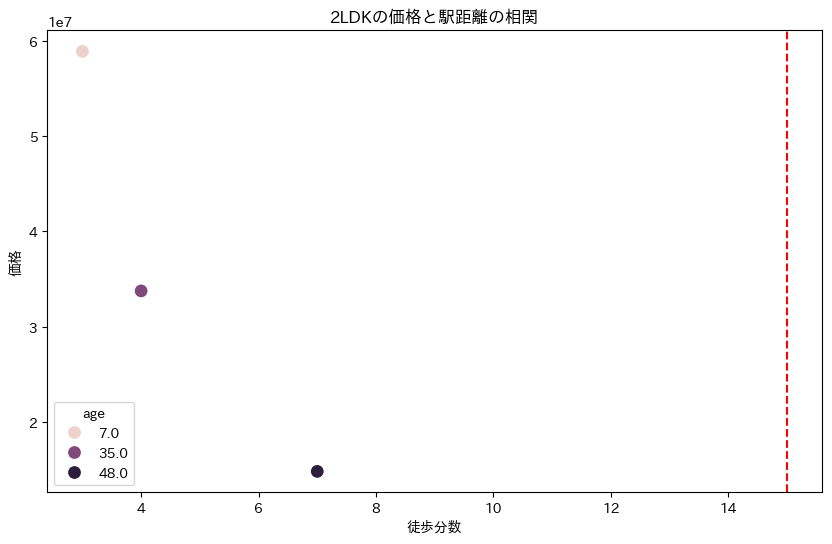

In [43]:
import japanize_matplotlib

class SimpleAnalyze:
    def __init__(self, db_path):
        self.db_path = db_path

    def analysis(self, target_ldk='2LDK'):
        #DBからデータを読み込む 
        with sqlite3.connect(self.db_path) as conn:
            df = pd.read_sql(f"SELECT * FROM 不動産 WHERE floor_plan = '{target_ldk}'", conn)

        # 築年数の計算
        df['year'] = df['Year_of_construction'].str.extract(r'(\d{4})').astype(float)
        df['age'] = 2025 - df['year']

        #散布図の作成
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=df, x='Walking_minutes', y='price', hue='age', s=100)
        
        #15分のところに線を引く
        plt.axvline(15, color='red', linestyle='--')
        
        plt.title(f'{target_ldk}の価格と駅距離の相関')
        plt.xlabel('徒歩分数')
        plt.ylabel('価格')
        plt.savefig(f'result_{target_ldk}.png')
        print(f"Graph saved: result_{target_ldk}.png")

analyzer = SimpleAnalyze('real_estate.db')
analyzer.analysis('2LDK')